In [1]:
import os
import numpy as np
import pickle
from multiprocessing import Pool, cpu_count
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks, blob_doh, blob_dog
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib inline

# Path utilities

In [2]:
DIR = './50_categories/'

In [3]:
image_paths = []
for cat in os.listdir(DIR):
    cat_path = os.path.join(DIR, cat)
    for img in os.listdir(cat_path):
        image_paths.append(os.path.join(cat_path, img))

In [4]:
def label_from_path(path):
    return path.split('/')[-2]

In [5]:
def category_paths(category):
    return list(filter(lambda x: category == label_from_path(x), image_paths))

# Feature selection

## Size

Some categories tend to have smaller photos than others

In [6]:
def img_size(img):
    """Get the size of the image array in megapixels"""
    return np.prod(img.shape[:2])/1e6

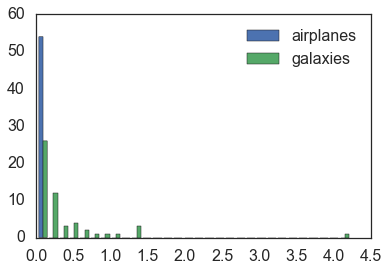

In [7]:
gsizes, asizes = [], []
for p in category_paths('galaxy'):
    img = imread(p)
    gsizes.append(img_size(img))
for p in category_paths('airplanes')[-54:]:
    img = imread(p)
    asizes.append(img_size(img))
plt.hist([asizes, gsizes], bins=30, label=['airplanes', 'galaxies']);plt.legend();

## Aspect ratio

Some objects are more likely to be photographed in portrait orientation than landscape orientation. For example, most airplane photos are landscape.

In [8]:
def aspect_ratio(img):
    """Calculate aspect ratio M/N from (M x N x 3) RGB image array"""
    return img.shape[0]/img.shape[1]

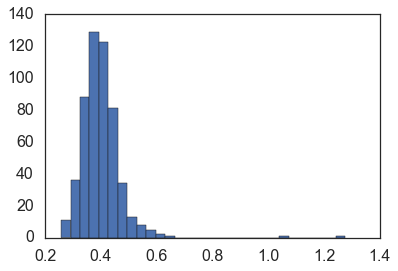

In [9]:
plane_ar = []
for p in category_paths('airplanes'):
    img = imread(p)
    plane_ar.append(aspect_ratio(img))

plt.hist(plane_ar, bins=30);

## Color statistics

The colors of the images can give us some information about what they show. As an example, we show the average red, green, and blue pixel values for frog vs killer whales. The killer whale photos have slightly lower blue pixel values than the images of the frogs.

The standard deviations of these distributions can give us the contrast of each of these colors.

In [10]:
def color_stats(img, color):
    """
    Calculate the average, std dev pixel value, and pixel value 
    range in color r, g, b, or k for an image array
    """
    if color.lower() == 'k' or len(img.shape) < 3:
        img = rgb2gray(img)
        ave = np.mean(img)
        std = np.std(img)
        ran = np.max(img) - np.min(img)
        return ave, std, ran
    color_index = ['r', 'g', 'b'].index(color.lower())
    ave = np.mean(img[:, :, color_index])
    std = np.std(img[:, :, color_index])
    ran = np.max(img[:, :, color_index])-np.min(img[:, :, color_index])
    return ave, std, ran

In [11]:
def color_ratio(img, color1, color2):
    ave1, _, _ = color_stats(img, color1)
    ave2, _, _ = color_stats(img, color2)
    return ave1/ave2

In [12]:
def color_diff(img, color1, color2):
    ave1, _, _ = color_stats(img, color1)
    ave2, _, _ = color_stats(img, color2)
    return ave1-ave2

In [13]:
frog_r, frog_g, frog_b = [], [], []
whale_r, whale_g, whale_b = [], [], []
for p in category_paths('frog'):
    img = imread(p)
    frog_r.append(color_stats(img, 'r'))
    frog_g.append(color_stats(img, 'g'))
    frog_b.append(color_stats(img, 'b'))
for p in category_paths('killer-whale'):
    img = imread(p)
    whale_r.append(color_stats(img, 'r'))
    whale_g.append(color_stats(img, 'g'))
    whale_b.append(color_stats(img, 'b'))

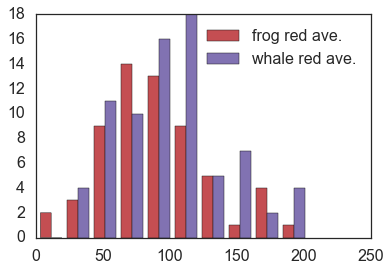

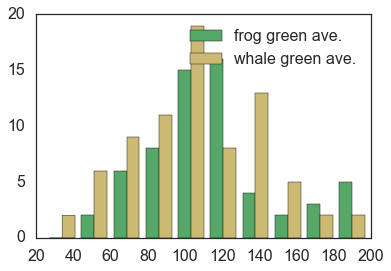

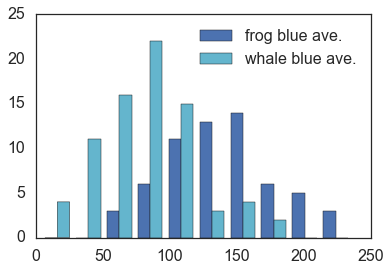

In [14]:
plt.hist([list(zip(*whale_r))[0], list(zip(*frog_r))[0]], color=['r', 'm'], label=['frog red ave.', 'whale red ave.']);plt.legend();plt.show();
plt.hist([list(zip(*whale_g))[0], list(zip(*frog_g))[0]], color=['g', 'y'], label=['frog green ave.', 'whale green ave.']);plt.legend();plt.show();
plt.hist([list(zip(*whale_b))[0], list(zip(*frog_b))[0]], color=['b', 'c'], label=['frog blue ave.', 'whale blue ave.']);plt.legend();plt.show();

## Color position

The location of and distance between the minimum and maximum pixel values in the image might also tell us some information about the image contents.

In [15]:
def min_max_color_position(img, color):
    """
    Find the x, y location of the maximum pixel value of the
    given color, normalized by the shape of the image.
    """
    if color.lower() == 'k' or len(img.shape) < 3:
        img = rgb2gray(img)
        min_y, min_x = np.unravel_index(np.argmin(img), img.shape)
        max_y, max_x = np.unravel_index(np.argmax(img), img.shape)
        return min_x, min_y, max_x, max_y
    color_index = ['r', 'g', 'b'].index(color.lower())
    min_y, min_x = np.unravel_index(np.argmin(img[:, :, color_index]), img[:, :, color_index].shape)
    max_y, max_x = np.unravel_index(np.argmax(img[:, :, color_index]), img[:, :, color_index].shape)
    return min_x/img.shape[1], min_y/img.shape[0], max_x/img.shape[1], max_y/img.shape[0]

In [16]:
def min_max_distance(img, color):
    """
    Find the distance between the minimum and maximum pixel values
    """
    minx, miny, maxx, maxy = min_max_color_position(img, color)
    return np.sqrt((maxx-minx)**2+(maxy-miny)**2)

## Color cross correlations

In [17]:
def color_xcorr(img, color1, color2):
    if len(img.shape) < 3:
        return 0.
    color_index1 = ['r', 'g', 'b'].index(color1.lower())
    color_index2 = ['r', 'g', 'b'].index(color2.lower())
    return np.corrcoef(np.array([img[:, :, color_index1].flatten(), img[:, :, color_index2].flatten()]))[0, 1]

## Number of saturated pixels

In [18]:
def num_bw(img, thresh=0.01):
    """
    Count the fraction of black/white pixels (defined as grayscale
    pixels below thresh/above 1-thresh)
    """
    imgbw = rgb2gray(img)
    k = len(list(zip(*np.where(imgbw < thresh))))/img_size(img)
    w = len(list(zip(*np.where(imgbw > (1-thresh)))))/img_size(img)
    return k, w

## Number of corners detected

We can use the Harris corner detection method to determine the number of corners in an image (normalized by the scale of the image). This could help differentiate categories that tend to have fewer sharp corners.

In [19]:
def num_corners(img):
    """Calculate the number of corner points using Harris corner detection"""
    if img.shape[-1]==3:
        img = rgb2gray(img)
    n = len(corner_peaks(corner_harris(img)))
    # normalize by image size
    return n/img_size(img)

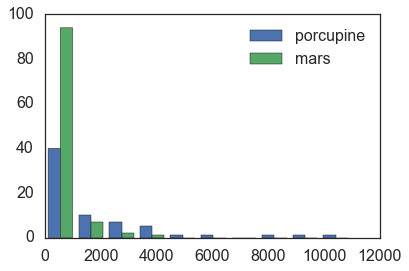

In [20]:
pcorn, mcorn = [], []
for p in category_paths('porcupine'):
    img = imread(p)
    pcorn.append(num_corners(img))
for p in category_paths('mars'):
    img = imread(p)
    mcorn.append(num_corners(img))
plt.hist([pcorn, mcorn], label=['porcupine', 'mars']);plt.legend();

## Number of blobs detected

Using the determinant of Hessian approach and difference of Gaussians, we can find the number of blobs within an image. We could also look at the number of blobs detected for every corner detected.

In [21]:
def num_blobs(img):
    """
    Calculate the number of blobs in an image using the determinant of 
    Hessian and difference of Gaussians
    """
    if img.shape[-1] == 3:
        img = rgb2gray(img)
    n_blob_dog = len(blob_dog(img))
    n_blob_doh = len(blob_doh(img))
    blob_diff = n_blob_doh-n_blob_dog
    return n_blob_doh, n_blob_dog, blob_diff

In [22]:
mblobs, zblobs = [], []
for p in category_paths('mars')[:10]:
    img = imread(p)
    n_blob, _, _ = num_blobs(img)
    mblobs.append(n_blob)
for p in category_paths('zebra')[:10]:
    img = imread(p)
    n_blob, _, _ = num_blobs(img)
    zblobs.append(n_blob)

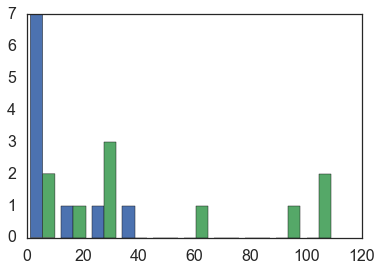

In [23]:
plt.hist([mblobs, zblobs], label=['mars', 'zebra']);plt.show()

# Extract all features

In [24]:
def extract_features(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        try:
            img = imread(image_path)
        except:
            continue
        size = img_size(img)
        asp = aspect_ratio(img)
        r_ave, r_std, r_ran = color_stats(img, 'r')
        g_ave, g_std, g_ran = color_stats(img, 'g')
        b_ave, b_std, b_ran = color_stats(img, 'b')
        k_ave, k_std, k_ran = color_stats(img, 'k')
        rg = color_ratio(img, 'r', 'g')
        gb = color_ratio(img, 'g', 'b')
        br = color_ratio(img, 'b', 'r')
        drg = color_diff(img, 'r', 'g')
        dgb = color_diff(img, 'g', 'b')
        dbr = color_diff(img, 'b', 'r')
        rgx = color_xcorr(img, 'r', 'g')
        gbx = color_xcorr(img, 'g', 'b')
        brx = color_xcorr(img, 'b', 'r')
        b, w = num_bw(img)
        rminx, rminy, rmaxx, rmaxy = min_max_color_position(img, 'r')
        gminx, gminy, gmaxx, gmaxy = min_max_color_position(img, 'g')
        bminx, bminy, bmaxx, bmaxy = min_max_color_position(img, 'b')
        kminx, kminy, kmaxx, kmaxy = min_max_color_position(img, 'k')
        rdist = min_max_distance(img, 'r')
        gdist = min_max_distance(img, 'g')
        bdist = min_max_distance(img, 'b')
        kdist = min_max_distance(img, 'k')
        n_corners = num_corners(img)
        n_blob_doh, n_blob_dog, blob_diff = num_blobs(img)
        if n_corners == 0:
            blob_per_corner = -1.
        else:
            blob_per_corner = np.mean(np.array([n_blob_doh, n_blob_dog]))/n_corners
        feature = [image_path,
                   size,
                   asp,
                   r_ave, r_std,
                   g_ave, g_std,
                   b_ave, b_std,
                   k_ave, k_std,
                   rg, gb, br,
                   drg, dgb, dbr,
                   rgx, gbx, brx,
                   b, w,
                   rminx, rmaxx,
                   gminx, gmaxx,
                   bminx, bmaxx,
                   kminx, kmaxx,
                   rdist, gdist, bdist, kdist,
                   n_corners,
                   n_blob_doh, n_blob_dog, blob_diff,
                   blob_per_corner]
        feature_list.append(feature)
    return feature_list

In [25]:
def split_seq(seq, size):
    newseq = []
    splitsize = 1.0/size*len(seq)
    for i in range(size):
        newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
    return newseq

In [26]:
def extract_parallel(image_paths, write=True):
    """
    Extract all of the features from all of the images.
    Takes about 20 minutes to run on a 1.3 GHz 4-core machine.
    Most of the time is spent detecting blobs.
    
    This has been taken + modified from the hw7-parallel-strawman
    example
    """
    numprocessors = cpu_count()
    split_image_paths = split_seq(image_paths, numprocessors)
    p = Pool(numprocessors)
    result = p.map_async(extract_features, split_image_paths)
    poolresult = result.get()
    combined_result = []
    for single_proc_result in poolresult:
        for single_image_result in single_proc_result:
            combined_result.append(single_image_result)
    if write:
        pickle.dump(combined_result, open('features.pkl', 'wb'))
    return combined_result

# Running the next cell will take a while!

In [27]:
extract_parallel(image_paths=image_paths);

# Training the classifier

Since there are different numbers of images in each category, we want to ensure that we aren't overtraining on categories with more images. To do this, we randomly select 30 images from each category to go into the training set. The remaining images are the validation set.

45 is a good number, since the smallest categories have 53 images, so this is an approximate 90/10 split.

In [28]:
def train_test_split(features, n=45):
    counts = {}
    i = 0
    train_X, train_y, test_X, test_y = [], [], [], []
    rand_ind = np.arange(0, len(features))
    np.random.shuffle(rand_ind)
    for i in rand_ind:
        f = features[i][1:]
        l = label_from_path(features[i][0])
        try:
            counts[l] += 0
        except KeyError:
            counts[l] = 0
        if counts[l] < n:
            train_X.append(f)
            train_y.append(l)
            counts[l] += 1
        else:
            test_X.append(f)
            test_y.append(l)
            counts[l] += 1
    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y), counts

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
def random_forest(train_X, train_y):
    """
    Train a random forest classifier.
    """
    clf = RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=-1)
    clf.fit(train_X, train_y)
    return clf

In [41]:
features = pickle.load(open('features.pkl', 'rb'))
n = 45
train_X, train_y, test_X, test_y, counts = train_test_split(features, n=n)
rf = random_forest(train_X, train_y)
pickle.dump(rf, open('random_forest.pkl', 'wb'))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.1s finished


# Evaluating the classifier

In [42]:
rf = pickle.load(open('random_forest.pkl', 'rb'))

## Confusion matrix

If the classification were perfect, we would expect a completely diagonal confusion matrix. We can see that that isn't the case with this classifier, but we can use the confusion matrix to understand where the classifier goes wrong.
There are some common misclassifications, seen as high values in the confusion matrix. For example, in this particular training, giraffes are frequently misclassified as llamas, saturn is confused for galaxy, and killer whale is confused for dolphin.

In [43]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix, classes):
    """
    Plots the confusion matrix
    """
    plt.figure(figsize=(15, 15))
    matrix = matrix / matrix.sum(axis=1)
    plt.imshow(cm, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical', size=10)
    plt.yticks(tick_marks, classes, size=10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.3s finished


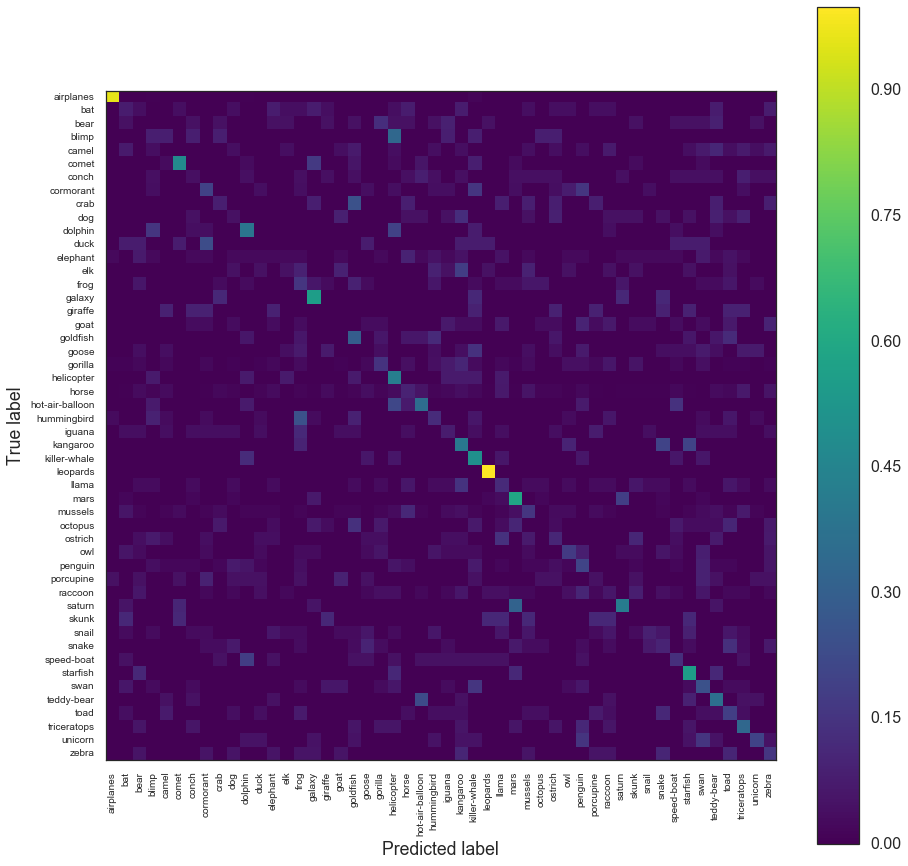

In [44]:
weights = np.array([1./(counts[t]-n) for t in test_y])
cm = confusion_matrix(test_y, rf.predict(test_X), sample_weight=weights)
classes = np.unique(test_y)
plot_confusion_matrix(cm, classes)

## Feature importances
One of the benefits of random forest classifiers is that they give the importance of the features used in the classification. We plot the feature importances here. It seems that the three most important features are the image size, aspect ratio, and cross-correlation coefficient between the red and green channels.

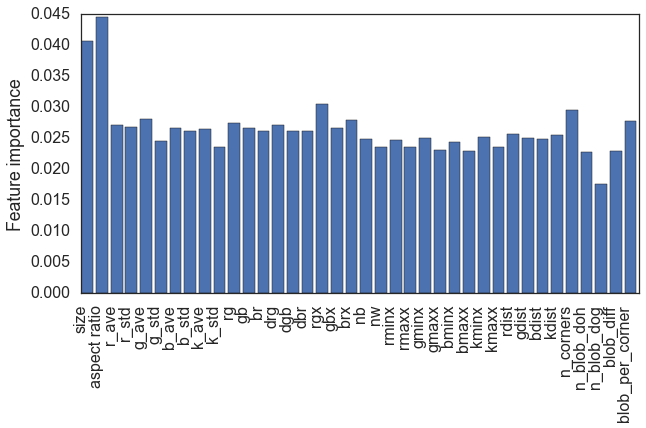

In [45]:
feature_labels = ['size',
                  'aspect ratio',
                  'r_ave', 'r_std',
                  'g_ave', 'g_std',
                  'b_ave', 'b_std',
                  'k_ave', 'k_std',
                  'rg', 'gb', 'br',
                  'drg', 'dgb', 'dbr',
                  'rgx', 'gbx', 'brx',
                  'nb', 'nw',
                  'rminx', 'rmaxx',
                  'gminx', 'gmaxx',
                  'bminx', 'bmaxx',
                  'kminx', 'kmaxx',
                  'rdist', 'gdist', 'bdist', 'kdist',
                  'n_corners',
                  'n_blob_doh', 'n_blob_dog', 'blob_diff',
                  'blob_per_corner'] 
ind = np.arange(len(feature_labels))
plt.figure(figsize=(10, 5))
plt.bar(ind, rf.feature_importances_)
plt.xlim(0, len(feature_labels))
plt.ylabel('Feature importance')
plt.xticks(ind, feature_labels, rotation='vertical');

## Scores
The average accuracy for our classifier is about 39%. However, there are some categories that the classifier performs particularly well on (>50% accuracy), including airplanes, leopards, mars, and saturn.

In [46]:
rf.score(test_X, test_y)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished


0.39769307923771313

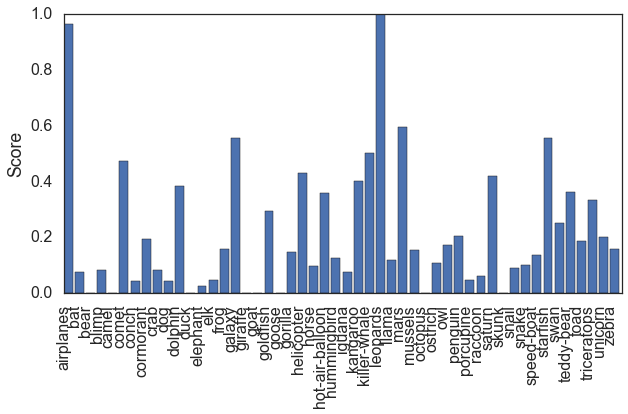

In [53]:
scores = []
rf.set_params(verbose=0)
for cat in sorted(counts.keys()):
    cat_X = test_X[np.where(test_y == cat)]
    weights = np.ones(len(cat_X))/len(cat_X)
    scores.append(rf.score(test_X[np.where(test_y == cat)],
                           test_y[np.where(test_y == cat)],
                           sample_weight=weights))
plt.figure(figsize=(10, 5))
ind = np.arange(len(sorted(counts.keys())))
plt.bar(ind, scores)
plt.ylabel('Score')
plt.xticks(ind, sorted(counts.keys()), rotation='vertical');

# Final classifier

In [59]:
def run_final_classifier(img_dir, rf_path='./random_forest.pkl', out='validation_results.txt'):
    # Extract features
    image_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
    print('Extracting features')
    features = extract_parallel(image_paths, write=False)
    # Predict classes
    print('Loading random forest model')
    rf = pickle.load(open(rf_path, 'rb'))
    print('Predicting classes')
    features = np.array(features)
    labels = [os.path.basename(f) for f in features[:, 0]]
    features = features[:, 1:]
    pred_labels = rf.predict(features)
    # Write to file
    print('File saved as', out)
    np.savetxt(out, np.array(list(zip(*[labels, pred_labels]))), fmt='%s', header='filename predicted_class\n'+'-'*30)

In [60]:
pred = run_final_classifier(img_dir='./50_categories/starfish/')

Extracting features
Loading random forest model
Predicting classes


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s


File saved as validation_results.txt


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished
